In [1]:
%%HTML
<style>div.prompt {display:none} .container { width:100% !important; }</style>

In [2]:
from sage.schemes.riemann_surfaces.riemann_surface import RiemannSurface
R.<z,w>=QQ[]

# Computing period matrices
Nils Bruin (SFU), August 1, 2017, Leiden

Based on joint work with Alexandre Zotine (SFU)

## 1. Complete algebraic Riemann surfaces

The algebraic way of getting them:
 1. Take an affine plane algebraic curve 
$$C^\mathrm{aff}\colon f(z,w)=0 \text{ with } f(z,w)\in \mathbb{C}[z,w].$$
 2. Take the smooth projective curve $C$ it determines
 3. Consider $C(\mathbb{C})$.

**Note:** By considering $f(z,w)\in \mathbb{C}(z)[w]$, we get $C=C(\mathbb{C})$ as a (ramified) finite cover of $\mathbb{P}^1(\mathbb{C})$.

Several relevant quantities:
 1. Genus $g$ of $C$
 2. $H_1(C,\mathbb{Z})\simeq \mathbb{Z}^{2g}$: Homology classes of paths on $C$
 3. $H^0(C,\Omega^1_C)\simeq \mathbb{C}^g$: Holomorphic differentials on $C$
 
**Integration pairing:** Given $\omega\in H^0(C,\Omega^1_C)$ and $[\gamma]\in H_1(C,\mathbb{Z})$ we can compute
 $$\int_\gamma \omega$$
 
**Given:**
 1. Basis $\omega_1,\ldots,\omega_g$ for $H^0(C,\Omega^1_C)$
 2. Basis $[\gamma_1],\ldots,[\gamma_{2g}]$ for $H_1(C,\mathbb{Z})$

**Period matrix:** $\mathbb{C}$-valued $g\times 2g$-dimensional matrix:
$$\begin{pmatrix}
\int_{\gamma_1}\omega_1&\int_{\gamma_2}\omega_1&\cdots&\int_{\gamma_{2g}}\omega_1\\
\int_{\gamma_1}\omega_2&\int_{\gamma_2}\omega_2&\cdots&\int_{\gamma_{2g}}\omega_2\\
\vdots&&\ddots&\vdots\\
\int_{\gamma_1}\omega_g&\int_{\gamma_2}\omega_g&\cdots&\int_{\gamma_{2g}}\omega_g\\
\end{pmatrix}$$
* The $\mathbb{Z}$-span of the columns gives a lattice $\Lambda\subset \mathbb{C}^g$.

* Analytic description of the Jacobian of $C$: $\mathbb{C}^g/\Lambda$.

* In this definition you can already see that the period matrix is only well-defined up to multiplication by $\mathrm{GL_{2g}}(\mathbb{Z})$ to the right and $\mathrm{GL}_{g}(\mathbb{C})$ to the left.

### Outline for an algorithm to approximate a period matrix:
 1. Determine a homology basis
 2. Determine a basis for holomorphic differentials (purely algebraic-geometric question)
 3. Numerically integrate the path integrals

## 2. Computing a homology basis

We consider the affine model
$$f(z,w)=0 \text{ where } f\in\mathbb{C}[z,w]$$
as a finite cover of the $z$-plane.

**Critical locus:**
$$B=\{ b\in \mathbb{C} : \mathrm{res}_w(f,\frac{\partial f}{\partial w})(b)=0\}$$

Let $d=\mathrm{deg}_w(f)$. Then the open part of $C$ covering $\mathbb{P}^1(\mathbb{C})\setminus (B\cup\{\infty\})$ is an unramified degree $d$ cover.

**Note:** $B$ also includes $z$-values of singularities of our model of $C$, so some critical points might not be branch points for $z\colon C\to\mathbb{P}^1$.

**Example:** $f(z,w)=w^2-z^4-z$

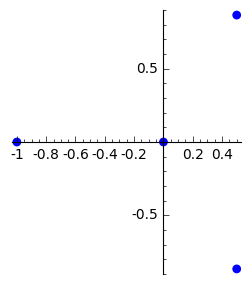

In [3]:
R.<z,w>=QQ[]
f=w^2-z^4-z
S=RiemannSurface(f)
points(S.branch_locus,size=40,aspect_ratio=1,figsize=4)

**Observations:**
 1. The fundamental group of $\mathbb{C}\setminus B$ is generated by taking loops around each $b\in B$.
 2. If we lift such loops to $C$ and decompose, we get generators for the fundamental group of $C$.
 3. We will need to analytically continue the algebraic function $w$ (which, when regarded as a "meromorphic function" on $\mathbb{C}$ is multi-valued) along these paths, which will be harder near branch points.

**Solution:** Build loops from edges of the Voronoi decomposition of $\mathbb{C}$ with respect to $B$. Add some extra points far away to ensure that cells around points in $B$ are finite.

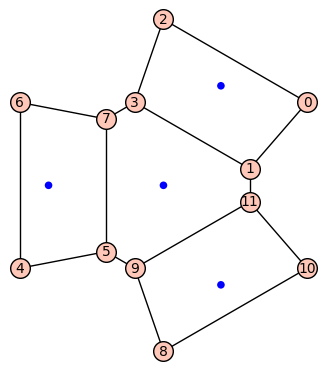

In [4]:
points(S.branch_locus,axes=false,size=30,figsize=5)+S.downstairs_graph().plot()

### Lifting the edges:
 1. Above each vertex $i$ with $z=z_i$, we determine the $d$ roots $w_{i,1},\ldots,w_{i,d}$ of $f(z_i,w)=0$
 2. For each edge $(i,j)$ in the Voronoi decomposition, we analytically continue the algebraic function $w(z)$ with $w(z_i)=w_{i,k}$ along the edge to find $w_{z_j}=w_{j,\sigma(k)}$, for some permutation $\sigma=\sigma_{i,j}\in S_d$.
 3. We get a graph with $d$ times the number of vertices: $(i,1),\ldots,(i,d)$ and $d$ times the number of edges: $(i,k)\rightarrow(j,\sigma_{i,j}(k))$.

This lifted graph on $C$ contains a homology basis.

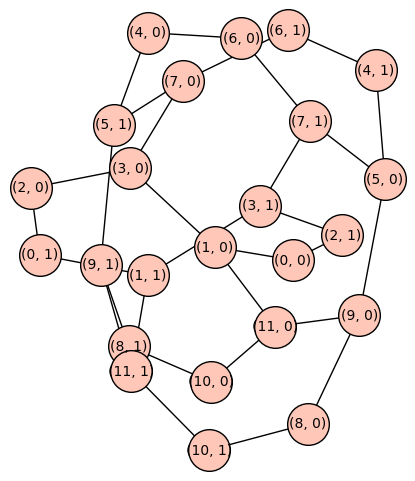

In [5]:
G=Graph(S.upstairs_edges())
G.plot(vertex_size=900,figsize=7)

In [6]:
G.plot3d(viewer="threejs")

Graphics3d Object

### Strategy for analytic continuation
* Given values $(z_0,w_1),\ldots,(z_0,w_d)$ to $f(z_0,w)=0$, choose $0<\delta\leq 1$ and set $z'=\delta z_1+(1-\delta)z_0$.

* Use Newton iteration starting with $(z,w)=(z',w_i)$ for the equation $f(z,w)=0$ which, _if it converges_ gives a solution $(z',w'_i)$.

* For $\epsilon=\frac{1}{3}\min_{k\neq l}\left|w_k-w_l\right|$, there is a bound $\Delta>0$ such that if $\delta\leq \Delta$, we have $\left|w'_i-w_i\right|<\epsilon$ (hence, we can reliably distinguish the different branches).

* For small enough $\delta$, Newton iteration will converge, so if convergence fails, or escapes the disc $|w-w_i|<\epsilon$, then just halve $\delta$.

**Explicit bounds:** (S. Kranich, ArXiv:1505.03432) gives an explicit formula for $\Delta$ in terms of $z_0$ and the coefficients of $f$.

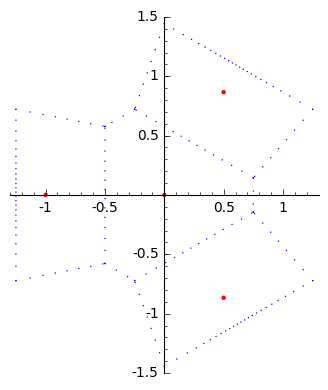

In [7]:
S.plot_paths().show(aspect_ratio=1)

In [8]:
S.plot_paths3d(thickness=2).show(viewer="threejs",axes=False)

Graphics3d Object

In [9]:
f=z*w^3+z^3+w
S=RiemannSurface(f)
S.plot_paths3d(thickness=2).show(viewer="threejs")

Graphics3d Object

### Monodromy generators

This lifted graph contains generators of the monodromy. In particular, we can compute the local monodromy by composing the computed permutations along the loops around the branch locus

In [10]:
table([["Branch point"+" ."*35,"local monodromy"]]+zip(S.branch_locus + [unsigned_infinity], S.monodromy_group()),header_row=True)

Branch point . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .,local monodromy
,
,
,
,
,
,
,
,
,


### Homology basis

 * A cycle basis for the lifted graph generates $H_1(C,\mathbb{Z})$.
 * $C(\mathbb{C})$ is an _oriented_ $2$-dimensional manifold, so $1$-cycles have a _signed_ intersection pairing:
 $\alpha,\beta$
 <table>
 <tr>
 <td><img src="intersection1.svg" style="width:100px"></img></td>
 <td><img src="intersection2.svg" style="width:100px"></img></td>
 <td><img src="intersection3.svg" style="width:100px"></img></td>
 </tr>
 <tr>
 <td>$\langle \alpha,\beta\rangle_P=1$</td>
 <td>$\langle \alpha,\beta\rangle_P=-1$</td>
 <td>$\langle \alpha,\beta\rangle_P=-\frac{1}{2}$</td>
 </tr>
 </table>
 
 $$\langle \alpha,\beta \rangle=\sum_{P\in \alpha\cap\beta} \langle \alpha,\beta \rangle_P$$
 * This defines an _alternating_ pairing on $H_1(C,\mathbb{Z})$. We can compute its Gram matrix on the cycle basis.
 
**Frobenius algorithm:** Brings an alternating pairing in standard form:
$$\begin{pmatrix}
0&c_1\\
-c_1&0\\
&&\ddots\\
&&&0&c_g\\
&&&-c_g&0\\
&&&&&0\\
&&&&&&\ddots\\
&&&&&&&0
\end{pmatrix}$$
 
**Theorem:** This pairing is _nondegenerate_ on $H_1(C,\mathbb{Z})$, with $c_1=\cdots=c_g=1$. Hence, there is a basis $\alpha_1\ldots,\alpha_g,\beta_1,\ldots,\beta_g$ with
$\langle \alpha_i,\beta_j\rangle=\delta_{ij}$ and $\langle \alpha_i,\alpha_j\rangle=\langle \beta_i,\beta_j\rangle=0$.

Using the Frobenius algorithm, we find such a basis as linear combination of a cycle basis of the upstairs graph.

## 3. Finding a cohomology basis
Holomorphic differentials on $C$ can be expressed in the form
$$h(z,w)\frac{df\, dz}{dw}\text{ where }\mathrm{totdeg}(h)\leq \mathrm{totdeg}(f)-3$$
If $C$ is nonsingular, then any such differential is holomorphic. For singularities one needs to impose conditions on $h(z,w)$ so that the pullback along the relevant blow-ups is regular. This is implemented in Singular for curves over $\mathbb{Q}$.

**TODO:** Provide a general implementation in Sage.

(Presently, the code works for curves defined over any exact field embedded in $\mathbb{C}$, but for field different from $\mathbb{Q}$ it needs a basis for the relevant space of polynomials $h$)

In [11]:
S.cohomology_basis()

[1, w, z]

## 4. Compute the integrals

We only have to integrate differentials $h(z,w)\frac{df\, dz}{dw}$ along straight lines $z=(1-t)z_0+tz_1$, and from the analytic continuation we already have a lot of sample points for $w$, which we can use to interpolate initial values for Newton iteration to compute $w(t)$.

Since we stay away from branch points and singularities, we know the integrand behaves nicely. Gauss-Legendre is probably a good integration scheme. We repeatedly double the number of evaluation points and estimate the error based on that.

In [12]:
show(S.period_matrix())

[1.3877787807814457e-16 + 2.7781638803006663*I    -0.7751978059036679 - 0.6181996213282022*I      0.430202326362528 - 0.8933243355469873*I     -1.741853658712075 + 1.3890819401503331*I  1.734723475976807e-16 + 0.5502494284375682*I    0.43020232636252753 + 0.3430749071094185*I]
[1.8214596497756474e-16 + 1.7866486710939695*I     0.5364535264458775 + 1.1139572259315484*I   -1.2054001322661958 - 0.27512471421878293*I    -0.4302023263625278 + 0.8933243355469844*I  2.498001805406602e-16 + 2.7781638803006627*I    -1.2054001322661956 - 2.5030391660818814*I]
[1.1102230246251565e-16 + 0.5502494284375674*I     2.1720559850746017 - 0.4957576046033465*I      1.741853658712073 - 1.3890819401503318*I    1.2054001322661962 + 0.27512471421878365*I 1.3877787807814457e-16 + 1.7866486710939715*I      1.7418536587120743 - 0.397566730943639*I]

### Riemann matrix

The period matrix, given a basis of holomorphic differentials $\omega_1,\ldots,\omega_g$ and a homology basis $\alpha_1,\ldots,\alpha_g,\beta_1,\ldots,\beta_g$, has the shape:
$$\left(\begin{array}{ccc|ccc}
\int_{\alpha_1} \omega_1&\cdots&\int_{\alpha_g} \omega_1&\int_{\beta_1} \omega_1&\cdots&\int_{\beta_g} \omega_1\\
\vdots&\ddots&\vdots&\vdots&\ddots&\vdots\\
\int_{\alpha_1} \omega_g&\cdots&\int_{\alpha_g} \omega_g&\int_{\beta_1} \omega_g&\cdots&\int_{\beta_g} \omega_g\\
\end{array}\right)=\left( M_\alpha \mid M_\beta \right)=M_\alpha\left(I_g \mid M_\alpha^{-1}M_\beta\right)$$

So we can use a change of basis of our differentials to get a square matrix $M=M_\alpha^{-1}M_\beta$ which only depends on our choice of 

**Theorem** (Riemann): This matrix is symmetric and its imaginary part is positive definite.

In [13]:
show(S.riemann_matrix())


[                  0.5 + 0.5669467095138411*I                  0.5 - 0.18898223650461385*I 2.7755575615628914e-16 + 0.377964473009228*I]
[  0.5000000000000003 - 0.18898223650461385*I   0.49999999999999983 + 0.9449111825230684*I   -0.49999999999999944 - 0.566946709513842*I]
[7.297389144134398e-17 + 0.3779644730092276*I                  -0.5 - 0.5669467095138409*I    0.9999999999999999 + 1.1338934190276828*I]

In [14]:
show([c.algdep(4) for c in S.riemann_matrix().list()])

[7*x^2 - 7*x + 4,
 7*x^2 - 7*x + 2,
 7*x^2 + 1,
 7*x^2 - 7*x + 2,
 7*x^2 - 7*x + 8,
 7*x^2 + 7*x + 4,
 7*x^2 + 1,
 7*x^2 + 7*x + 4,
 7*x^2 - 14*x + 16]

## 5. Applications

### Endomorphisms and isogenies
In order to find endomorphism it is easiest to consider integer linear transformations on the homology:

From:
$$\begin{pmatrix}I\mid M\end{pmatrix}
\begin{pmatrix} D&B\\C&A\end{pmatrix}=
\begin{pmatrix} MA+B \mid MC+D\end{pmatrix}$$

Bringing this in standard form:
$$\begin{pmatrix}
I \mid (MA+B)^{-1}(MC+D)\end{pmatrix}$$

For an endomorphism we would be able to find a transformation $\begin{pmatrix}D&B\\C&A\end{pmatrix}$ that satisfies the equation
$$(MC+D)-(MA+B)M=0$$

This gives $g^2$ equation with coefficients in $\mathbb{C}$ in $4g^2$ integer variables. We can use LLL to find approximate solutions.

In [15]:
S=RiemannSurface(w^2-z^3+1)
show(S.endomorphism_basis())

[
[1 0]  [ 0 -1]
[0 1], [ 1  1]
]

### An example from Drew Sutherland

Two genus 3 curves (one hyperelliptic, the other non-hyperelliptic) with isogenous Jacobians (based on L-series computations):
$$C_1: -x^2y^2 - xy^3 + x^3 + 2x^2y + 2xy^2 - x^2 - y = 0 $$
$$C_2: y^2 + (x^4+x^3+x^2+1)  y = x^7 - 8x^5 - 4x^4 + 18x^3 - 3x^2 - 16x + 8 $$

In [16]:
RR.<x,y>=QQ[]
f1=-x^2*y^2 - x*y^3 + x^3 + 2*x^2*y + 2*x*y^2 - x^2 - y
f2=y^2 + (x^4+x^3+x^2+1) * y -( x^7 - 8*x^5 - 4*x^4 + 18 * x^3 - 3*x^2 - 16*x + 8)
S1=RiemannSurface(f1)
S2=RiemannSurface(f2)
%time E12 = S1.isogeny_basis(S2); E12

CPU times: user 14.9 s, sys: 18.6 ms, total: 14.9 s
Wall time: 15 s


In [17]:
show(E12)
E12[0].smith_form()[0]

[
[ 0  1  0  2 -1  1]
[-2 -1  2  0 -1 -1]
[ 0  1  0  0 -1 -1]
[-2 -1  0 -2  1 -1]
[ 0  1  0  0 -1  1]
[ 0  2  2  0  0 -2]
]

[1 0 0 0 0 0]
[0 2 0 0 0 0]
[0 0 2 0 0 0]
[0 0 0 2 0 0]
[0 0 0 0 2 0]
[0 0 0 0 0 4]

In [18]:
E21 = S2.isogeny_basis(S1)
E12[0]*E21[0]

[-4  0  0  0  0  0]
[ 0 -4  0  0  0  0]
[ 0  0 -4  0  0  0]
[ 0  0  0 -4  0  0]
[ 0  0  0  0 -4  0]
[ 0  0  0  0  0 -4]

### Recognizing isogeny factors
Kani-Rosen show that idempotents in the endomorphism ring are in bijection to decompositions of an abelian variety. If you can compute endomorphism rings, you can solve for idempotents. The following takes a little too long to execute during the talk:

We reconstruct the matrices and we solve for the idempotent, i.e., we solve the equation
$$(aE_1+bE_2+cE_3)^2=(aE_1+bE_2+cE_3)$$
and we compute the characteristic polynomials of the idempotent elements (we compute the ranks).

In [19]:
E=[matrix(12,12,c) for c in [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [-1, 0, -1, -1, -1, -1, 0, -1, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, 1, 0, 0, -1, 0, 0, -1, 1, 0, -1, 0, -1, 0, 0, 0, -1, 1, 0, -2, 3, 2, -1, 0, -1, 1, 1, 1, 0, 1, -1, 1, -1, -1, 0, 0, 1, 0, 0, -1, -1, 0, 1, 1, -1, -1, 1, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, -1, 1, 0, -1, 0, -1, -2, 1, 1, 0, 0, 1, 2, 0, 1, 0, 0, 1, 3, -1, -1, 0, -1, 0, 0, -2, -1, -1, -1, 0, 2, -1, -1, 1, -2, 0, 0, 1, 1, -1, 0, -1, -1, 0, 1, -1, 0, 2, -1, 0, -1, -1, 0, 0, 0, 0, 0, 0, -1, 1, -1, 1, 0, -1, 0, -1, -1, 1, 0], [-2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, -1, -1, 2, 2, 0, -1, 0, 0, 0, 1, 3, 0, -1, -1, -1, 0, 0, 0, -1, -1, -1, 0, 1, -1, -1, -1, -3, -3, 0, -1, -1, -2, -3, -1, 0, -1, 0, -1, 1, 2, 0, 0, 0, 0, 0, 1, 1, 0, -1, 0, 2, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, -3, -1, 0, 0, -1, -2, -1, -1, -1, -1, 0, 3, 0, -1, -1, 0, 1, 2, 2, -1, -3, 1, 2, 1, 1, 0, 0, 3, 2, 2, 2, 0, -3, 2, 1, 0, 1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -3, 1, 0, 1, 0, -1, 0, -1, 0, 1, 1, -1, -2, 0, -1, 0, 0, 0, -1, -1, 0, 0]]

_.<a,b,c>=QQ[]
A=a*E[0]+b*E[1]+c*E[2]
[(s[a]*E[0]+s[b]*E[1]+s[c]*E[2]).charpoly().factor() for s in ideal((A^2-A).list()).variety()]

[(x - 1)^4 * x^8,
 x^4 * (x - 1)^8,
 x^4 * (x - 1)^8,
 x^12,
 (x - 1)^12,
 (x - 1)^4 * x^8,
 (x - 1)^4 * x^8,
 x^4 * (x - 1)^8]

A little more modest example: a bielliptic genus $2$ curve. We can check that its jacobian is isogenous to a product of elliptic curves:
$$C\colon y^2=x^6+x^4-5x^2+2$$
$$E_1\colon y^2=x^3+x^2-5x+2$$
$$E_2\colon y^2=1+x-5x^2+2x^3$$


In [20]:
f1=y^2-(x^6+x^4-5*x^2+2)
f2=y^2-(x^3+x^2-5*x+2)
f3=y^2-(1+x-5*x^2+2*x^3)
S=RiemannSurface(f1)
E1=RiemannSurface(f2)
E2=RiemannSurface(f3)
%time A=S.isogeny_basis(E1+E2);
show(A)

CPU times: user 1.18 s, sys: 966 µs, total: 1.18 s
Wall time: 1.18 s


[
[ 0  1  0  0]  [-2  0 -1  0]
[ 0  0  0 -1]  [ 1  0  0  0]
[ 0  0  0  1]  [ 1  0  0  0]
[ 0  1  0  1], [ 1  0  1  0]
]

In [21]:
f1=x^4*y - 2*x^2*y^3 - 3*y^5 + x^4 - 6*x^2*y^2 + 9*y^4 - 4
f2=y^2-(x^6-x^5+1)
f3=y^2-(2*x^5 + 27*x^4 - 54*x^2 + 27)
S1=RiemannSurface(f1)
S2=RiemannSurface(f2)
S3=RiemannSurface(f3)

In [22]:
%time E=S1.isogeny_basis(S2+S2+S3)

CPU times: user 7.51 s, sys: 46.7 ms, total: 7.56 s
Wall time: 7.56 s


In [23]:
{sum(e).rank() for e in subsets(E) if len(e)>0}

{4, 8, 12}